In [ ]:
import os
import random
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

import requests
import tarfile
import PIL
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import random
import shutil

# Define the path to the main dataset directory containing the class folders
data_dir = '/content/gdrive/MyDrive/full_stack/Banana Ripeness Dataset'

# Define the paths to the train, test, and valid directories
train_dir = 'content/train'
test_dir = 'content/test'
valid_dir = 'content/valid'

# Define the train/test/validation splits
train_split = 0.7
test_split = 0.2
valid_split = 0.1

# Loop through each class folder and create train/test/valid directories for that class
for class_folder in os.listdir(data_dir):
    # Create the train/test/valid directories for this class
    os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, class_folder), exist_ok=True)

    # Get a list of all files in this class folder
    files = os.listdir(os.path.join(data_dir, class_folder))

    # Shuffle the file list randomly
    random.shuffle(files)

    # Calculate the number of files to use for each split
    num_files = len(files)
    num_train = int(num_files * train_split)
    num_test = int(num_files * test_split)
    num_valid = num_files - num_train - num_test

    # Copy the files into the appropriate train/test/valid directories
    for i, file_name in enumerate(files):
        file_path = os.path.join(data_dir, class_folder, file_name)
        if i < num_train:
            shutil.copy(file_path, os.path.join(train_dir, class_folder, file_name))
        elif i < num_train + num_test:
            shutil.copy(file_path, os.path.join(test_dir, class_folder, file_name))
        else:
            shutil.copy(file_path, os.path.join(valid_dir, class_folder, file_name))


In [ ]:
train_dir = "/content/gdrive/MyDrive/full_stack/Banana Ripeness Dataset/train"
val_dir = "/content/gdrive/MyDrive/full_stack/Banana Ripeness Dataset/valid"

BATCH_SIZE = 32
IMG_SIZE = (320, 320)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode="nearest",
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

Found 362 images belonging to 4 classes.
Found 56 images belonging to 4 classes.


In [ ]:
# Create the base model
base_model = Xception(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))

# Freeze the base model
base_model.trainable = False

# Add a custom classification head
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
optimizer_dict = {
    "Adam" : Adam
}

In [ ]:
# Define the history dict
history_dict = {}

# Define the number of output layers
num_output_layers = [1, 2]

# Loop over all the combinations of optimizers, learning rates, batch sizes, and number of output layers
for optimizer_name, optimizer in optimizer_dict.items():
    for num_layers in num_output_layers:
        # Add the output layers
        if num_layers == 1:
            output1 = Dense(train_generator.num_classes, activation='softmax')(x)
            outputs = [output1]
        elif num_layers == 2:
            x = Dense(1024, activation='relu')(x)
            output1 = Dense(train_generator.num_classes, activation='softmax')(x)

        # Combine base model and output layers
        model = Model(inputs=inputs, outputs=outputs)

        # Freeze all the layers in the base model
        for layer in base_model.layers:
            layer.trainable = False

        # Compile the model with the current optimizer, learning rate, and batch size
        model.compile(optimizer=optimizer(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model with the current batch size and output layers
        history = model.fit(train_generator,epochs=20,validation_data=val_generator)

        # Add the model history to the history_dict dictionary with the current hyperparameters as the key
        hyperparameters = (optimizer_name, num_layers)
        history_dict[hyperparameters] = history.history

        # Save the model in Keras format
        model.save('my_model.h5')
        
        # Convert the model to TFLite format
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        tflite_model = converter.convert()
        
        # Save the TFLite model to a file
        open("my_model.tflite", "wb").write(tflite_model)

Epoch 1/20
12/12 [==============================] - 210s 16s/step - loss: 1.2418 - accuracy: 0.4033 - val_loss: 1.1395 - val_accuracy: 0.4821
Epoch 2/20
12/12 [==============================] - 12s 980ms/step - loss: 1.0418 - accuracy: 0.6188 - val_loss: 1.0058 - val_accuracy: 0.6429
Epoch 3/20
12/12 [==============================] - 12s 979ms/step - loss: 0.9266 - accuracy: 0.6492 - val_loss: 0.9447 - val_accuracy: 0.6429
Epoch 4/20
12/12 [==============================] - 11s 896ms/step - loss: 0.8537 - accuracy: 0.6602 - val_loss: 0.8613 - val_accuracy: 0.6607
Epoch 5/20
12/12 [==============================] - 11s 889ms/step - loss: 0.8104 - accuracy: 0.6961 - val_loss: 0.8247 - val_accuracy: 0.7143
Epoch 6/20
12/12 [==============================] - 12s 987ms/step - loss: 0.7478 - accuracy: 0.7155 - val_loss: 0.7927 - val_accuracy: 0.6607
Epoch 7/20
12/12 [==============================] - 12s 982ms/step - loss: 0.7269 - accuracy: 0.6851 - val_loss: 0.7510 - val_accuracy: 0.7500


Epoch 1/20
12/12 [==============================] - 15s 1s/step - loss: 0.5001 - accuracy: 0.7983 - val_loss: 0.5582 - val_accuracy: 0.8036
Epoch 2/20
12/12 [==============================] - 12s 981ms/step - loss: 0.4876 - accuracy: 0.8260 - val_loss: 0.5465 - val_accuracy: 0.8036
Epoch 3/20
12/12 [==============================] - 12s 967ms/step - loss: 0.5027 - accuracy: 0.8066 - val_loss: 0.5211 - val_accuracy: 0.8214
Epoch 4/20
12/12 [==============================] - 12s 969ms/step - loss: 0.4959 - accuracy: 0.8425 - val_loss: 0.5163 - val_accuracy: 0.8036
Epoch 5/20
12/12 [==============================] - 11s 940ms/step - loss: 0.4623 - accuracy: 0.8564 - val_loss: 0.5218 - val_accuracy: 0.8036
Epoch 6/20
12/12 [==============================] - 12s 979ms/step - loss: 0.4484 - accuracy: 0.8260 - val_loss: 0.4945 - val_accuracy: 0.7857
Epoch 7/20
12/12 [==============================] - 12s 1s/step - loss: 0.4656 - accuracy: 0.8425 - val_loss: 0.5034 - val_accuracy: 0.8036
Epoch

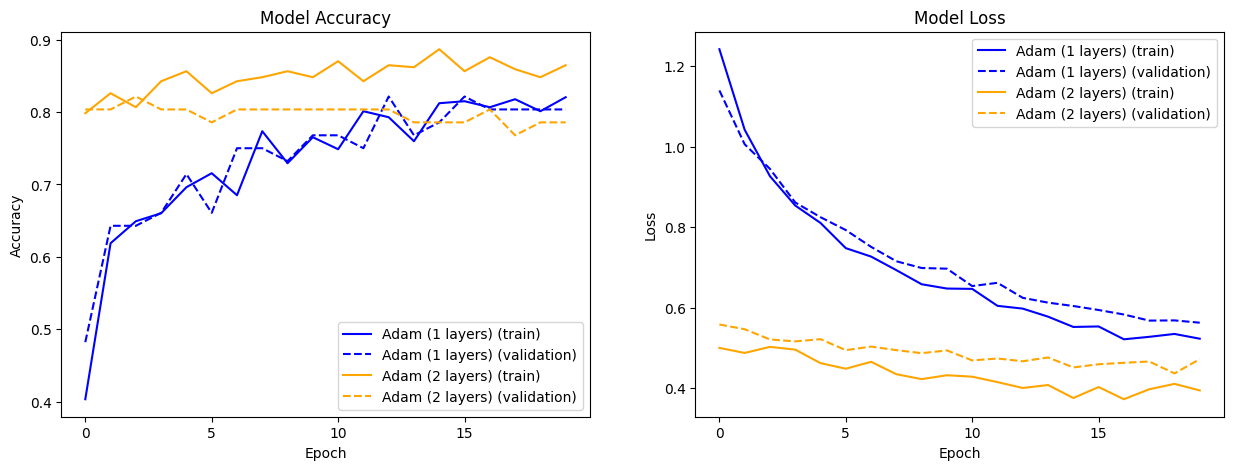

In [ ]:
import matplotlib.pyplot as plt

# Define the colors for each optimizer
colors = {('Adam', 1): 'blue', ('Adam', 2): 'orange', ('AdaGrad', 1): 'purple', ('AdaGrad', 2): 'red'}

# Define the figure and axes for the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the accuracy and loss for each model in the history_dict
for hyperparameters, history in history_dict.items():
    optimizer_name, num_layers = hyperparameters
    color = colors[(optimizer_name, num_layers)]
    label_train = f"{optimizer_name} ({num_layers} layers) (train)"
    label_val = f"{optimizer_name} ({num_layers} layers) (validation)"
    ax1.plot(history['accuracy'], color=color, label=label_train)
    ax1.plot(history['val_accuracy'], color=color,  linestyle='--', label=label_val)
    ax2.plot(history['loss'], color=color,  label=label_train)
    ax2.plot(history['val_loss'], color=color,  linestyle='--',  label=label_val)

# Set the titles and labels for the plots
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Set the x-axis tick frequency to 5
ax1.set_xticks(range(0, len(history['accuracy']), 5))
ax2.set_xticks(range(0, len(history['accuracy']), 5))

# Show the plots
plt.show()